In [1]:
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from multiprocessing import Pool
import pandas as pd
import pickle
import glob
from tqdm.auto import tqdm
import os
from datetime import datetime
import json
import geopandas as gpd
from pathlib import Path

In [3]:
# point this at the folder full of csv files from the extraction script
tile_step_folder = '/mnt/2TB Working/Projects/Dam forecast/v4/forecast/time steps'
# the output location for this script
output_folder = '/mnt/2TB Working/Projects/Dam forecast/v4/forecast/preds v3'
Path(output_folder).mkdir(exist_ok=True)
# location of model file
model_folder = '/mnt/2TB Working/Projects/Dam forecast/v4'
model_name = 'dam_forecast_8-9-22.pkl'
model_path = os.path.join(model_folder,model_name)
'found model?',os.path.isfile(model_path)

('found model?', True)

In [4]:
# load in data from meta file
with open(model_path.replace('.pkl','.json'), 'r') as fp:
    meta_dict = json.load(fp)

In [5]:
# load up model
xgb_reg_model = pickle.load(open(model_path, "rb"))

In [6]:
# get a refence to each csv file
time_steps = glob.glob(tile_step_folder+'/*.csv')
len(time_steps)

132

In [7]:
# work out which cols we need to remove, other the model wont know whats happening
cols_to_keep = meta_dict['col_names']
ts_df = pd.read_csv(time_steps[0])
drop_cols = []
for col in ts_df.columns:
    if col not in cols_to_keep:
        drop_cols.append(col)

In [8]:
cols = ts_df.columns

In [9]:
ts_df.columns

Index(['Unnamed: 0', 'file_name', 'area', 'area_2', 'SRC_DATE',
       'file_name_pred', 'class', 'class_name', 'geometry',
       'avgt_8_months before', 'avgt_5_months before', 'avgt_11_months before',
       'avgt_1_months before', 'avgt_6_months before', 'avgt_9_months before',
       'avgt_10_months before', 'avgt_3_months before', 'avgt_2_months before',
       'avgt_7_months before', 'avgt_4_months before', 'avgt_12_months before',
       'avgt_0_months before', 'rain_2_months before', 'rain_5_months before',
       'rain_12_months before', 'rain_6_months before', 'rain_8_months before',
       'rain_11_months before', 'rain_4_months before',
       'rain_10_months before', 'rain_1_months before', 'rain_7_months before',
       'rain_3_months before', 'rain_9_months before', 'rain_0_months before'],
      dtype='object')

In [10]:
cols

Index(['Unnamed: 0', 'file_name', 'area', 'area_2', 'SRC_DATE',
       'file_name_pred', 'class', 'class_name', 'geometry',
       'avgt_8_months before', 'avgt_5_months before', 'avgt_11_months before',
       'avgt_1_months before', 'avgt_6_months before', 'avgt_9_months before',
       'avgt_10_months before', 'avgt_3_months before', 'avgt_2_months before',
       'avgt_7_months before', 'avgt_4_months before', 'avgt_12_months before',
       'avgt_0_months before', 'rain_2_months before', 'rain_5_months before',
       'rain_12_months before', 'rain_6_months before', 'rain_8_months before',
       'rain_11_months before', 'rain_4_months before',
       'rain_10_months before', 'rain_1_months before', 'rain_7_months before',
       'rain_3_months before', 'rain_9_months before', 'rain_0_months before'],
      dtype='object')

In [11]:
# loop over each csv file and run model
# for time_step in tqdm(time_steps):
def run_model(time_step):
#     read csv file
    full_ts_df = pd.read_csv(time_step)
#     drop cols we dont need
    ts_df = full_ts_df.drop(columns=drop_cols)
#     make sure the cols are in the same order as when it was trained
    ts_df = ts_df.reindex(sorted(ts_df.columns), axis=1)
#     run model
    preds = xgb_reg_model.predict(ts_df)
        
#     grab the filename which should also tell us the date
    file_name = os.path.basename(time_step)
    date = file_name.replace('.csv','')    
#     make a new df with just files names as a reference
    limited_df = full_ts_df[['file_name']].copy()
#     place the preds into the new df
    limited_df[date] = preds
#     save the df out to disk
    csv_out_path = os.path.join(output_folder,file_name)
    limited_df.to_csv(csv_out_path)
    

In [12]:
with Pool(4) as p:
    list(tqdm(p.imap(run_model,time_steps),total=len(time_steps)))

  0%|          | 0/132 [00:00<?, ?it/s]

In [13]:
# get a list of all prediction files
outputs_csvs = glob.glob(output_folder+'/*.csv')
len(outputs_csvs)

132

In [14]:
# open one input csv and read the non weather data
base_data = pd.read_csv(time_steps[0])
drop_list = []
for col in base_data.columns:
    if 'before' in col:
        drop_list.append(col)
    if 'Unnamed' in col:
        drop_list.append(col)
        
base_data = base_data.drop(columns=drop_list)
base_data.head()

,file_name,area,area_2,SRC_DATE,file_name_pred,class,class_name,geometry
0,arcgisonline_1286093.tif,1782.758036,1231.106859,20170126.0,arcgisonline_1286093_pred_and_score.tif,0,dam and water,POINT (146.6588069486813 -36.09348834105707)
1,arcgisonline_1337387.tif,1917.350912,1042.750433,20151214.0,arcgisonline_1337387_pred_and_score.tif,0,dam and water,POINT (145.805796616269 -38.45117124599049)
2,arcgisonline_1702518.tif,2300.790143,698.207560,20141023.0,arcgisonline_1702518_pred_and_score.tif,0,dam and water,POINT (145.6944661230982 -41.09943117172507)
3,arcgisonline_1274916.tif,403.480805,90.273377,20160112.0,arcgisonline_1274916_pred_and_score.tif,0,dam and water,POINT (141.2265930940858 -36.64661979986719)
4,arcgisonline_704977.tif,1774.881116,749.984968,20160502.0,arcgisonline_704977_pred_and_score.tif,0,dam and water,POINT (149.8368300621361 -32.87745562956079)


In [15]:
# make empty df to load preds into, we need to keep this separate from the base data we we can sort it by date 
preds_df = pd.DataFrame()
# loop over each pred csv
for csv in tqdm(outputs_csvs):
#     get the file name
    file_name = os.path.basename(csv)
#     get the date from the name
    date = file_name.replace('.csv','')
#     open file
    current_df = pd.read_csv(csv)
#     extract the preds col
    preds = current_df[date].to_list()
#     name date a proper python date
    date_fixed = datetime.strptime(date, '%Y-%m')
#     load preds into main df
    preds_df[date_fixed] = preds
# sort the cols by date
preds_df = preds_df[sorted(preds_df.columns)]

  0%|          | 0/132 [00:00<?, ?it/s]

/home/nick/anaconda3/envs/XGB/lib/python3.7/site-packages/ipykernel_launcher.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  app.launch_new_instance()


In [22]:
# have a look at the df and make sure it looks good

preds_df[preds_df < 0] = 0
preds_df

,2011-01-01,2011-02-01,2011-03-01,2011-04-01,2011-05-01,2011-06-01,2011-07-01,2011-08-01,2011-09-01,2011-10-01,...,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01
0,1037.48800,1053.50700,896.88464,1140.41520,881.16736,1145.77280,805.65314,917.93854,935.47174,695.54720,...,724.96954,698.01280,792.70294,866.03284,815.68530,893.91850,1243.70120,1019.80334,1031.24950,901.91930
1,1099.76220,1077.12600,1010.53046,1064.97800,1123.20970,1071.59520,1153.49660,958.43260,986.71906,1131.42660,...,1098.90830,1046.74480,1137.85830,1043.41030,1104.78030,1020.18290,1092.20890,1141.66440,1172.87800,1080.48430
2,1308.73550,1219.70250,1252.01270,1228.18000,1385.65320,1265.30810,1426.19640,1162.76900,1398.60220,1265.82620,...,1348.83450,1285.95480,1401.17640,1442.15170,1509.76070,1256.76230,1276.23730,1383.73330,1409.57910,1460.00300
3,191.84300,180.48946,175.35230,147.74720,151.02386,145.30005,178.12225,184.98430,196.47678,199.94344,...,84.47498,83.78002,76.75905,96.19508,113.60881,144.66158,161.54823,169.86823,127.90292,104.93296
4,1044.60310,1044.54590,941.78143,913.07965,959.74493,850.73486,822.72690,831.92030,976.84190,895.21980,...,1036.19410,1097.54850,1071.25700,909.09570,695.66700,933.10210,1014.37590,1067.67710,1101.34950,990.05084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1246412,706.00183,664.73334,648.96620,670.28420,615.40090,680.02290,622.23420,659.26800,672.93450,689.40480,...,559.27830,641.70500,738.12640,627.98330,662.77050,697.28640,666.46820,776.96576,803.82294,781.54570
1246413,347.11044,441.30260,407.11893,360.18040,398.54266,417.62590,378.48068,390.92636,415.46580,408.72290,...,429.49220,315.12094,391.97522,479.96326,483.22827,278.88733,790.50714,667.09680,473.12082,386.96780
1246414,1536.43490,1334.01220,1412.35800,1571.73140,1598.55500,1325.60390,1304.42070,1312.96100,1262.91190,1416.83140,...,976.37730,929.64280,938.09950,826.66940,861.68760,898.92676,826.69410,902.74910,1008.17456,1290.91520
1246415,6602.23900,4949.24100,6849.61300,6396.62800,5980.06600,5908.50830,6434.35060,5507.56350,6110.91100,5854.14060,...,7012.62900,6083.82670,5693.73900,5677.65670,6706.80500,5397.63200,7264.95100,6407.71900,5612.84600,6009.21200


In [17]:
# join the base data with the preds
preds_with_meta = pd.concat([base_data, preds_df], axis=1)
preds_with_meta.head()

,file_name,area,area_2,SRC_DATE,file_name_pred,class,class_name,geometry,2011-01-01 00:00:00,2011-02-01 00:00:00,...,2021-03-01 00:00:00,2021-04-01 00:00:00,2021-05-01 00:00:00,2021-06-01 00:00:00,2021-07-01 00:00:00,2021-08-01 00:00:00,2021-09-01 00:00:00,2021-10-01 00:00:00,2021-11-01 00:00:00,2021-12-01 00:00:00
0,arcgisonline_1286093.tif,1782.758036,1231.106859,20170126.0,arcgisonline_1286093_pred_and_score.tif,0,dam and water,POINT (146.6588069486813 -36.09348834105707),1037.4880,1053.50700,...,724.96954,698.01280,792.70294,866.03284,815.68530,893.91850,1243.70120,1019.80334,1031.24950,901.91930
1,arcgisonline_1337387.tif,1917.350912,1042.750433,20151214.0,arcgisonline_1337387_pred_and_score.tif,0,dam and water,POINT (145.805796616269 -38.45117124599049),1099.7622,1077.12600,...,1098.90830,1046.74480,1137.85830,1043.41030,1104.78030,1020.18290,1092.20890,1141.66440,1172.87800,1080.48430
2,arcgisonline_1702518.tif,2300.790143,698.207560,20141023.0,arcgisonline_1702518_pred_and_score.tif,0,dam and water,POINT (145.6944661230982 -41.09943117172507),1308.7355,1219.70250,...,1348.83450,1285.95480,1401.17640,1442.15170,1509.76070,1256.76230,1276.23730,1383.73330,1409.57910,1460.00300
3,arcgisonline_1274916.tif,403.480805,90.273377,20160112.0,arcgisonline_1274916_pred_and_score.tif,0,dam and water,POINT (141.2265930940858 -36.64661979986719),191.8430,180.48946,...,84.47498,83.78002,76.75905,96.19508,113.60881,144.66158,161.54823,169.86823,127.90292,104.93296
4,arcgisonline_704977.tif,1774.881116,749.984968,20160502.0,arcgisonline_704977_pred_and_score.tif,0,dam and water,POINT (149.8368300621361 -32.87745562956079),1044.6031,1044.54590,...,1036.19410,1097.54850,1071.25700,909.09570,695.66700,933.10210,1014.37590,1067.67710,1101.34950,990.05084


In [18]:
# export out to csv file
final_export = os.path.join(output_folder,'full preds v3.csv')
final_export

'/mnt/2TB Working/Projects/Dam forecast/v4/forecast/preds v3/full preds v3.csv'

In [19]:
# export csv
preds_with_meta.to_csv(final_export)

In [23]:
# read df with geopandas 

preds_with_meta_gdf = gpd.GeoDataFrame(preds_with_meta,geometry='geometry',crs='EPSG:4326')

# geom = preds_with_meta_gdf['geometry']

# preds_with_meta_gdf['geometry'] = gpd.GeoSeries.from_wkt(geom,crs='EPSG:4326')

preds_with_meta_gdf.head()

,file_name,area,area_2,SRC_DATE,file_name_pred,class,class_name,geometry,2011-01-01 00:00:00,2011-02-01 00:00:00,...,2021-03-01 00:00:00,2021-04-01 00:00:00,2021-05-01 00:00:00,2021-06-01 00:00:00,2021-07-01 00:00:00,2021-08-01 00:00:00,2021-09-01 00:00:00,2021-10-01 00:00:00,2021-11-01 00:00:00,2021-12-01 00:00:00
0,arcgisonline_1286093.tif,1782.758036,1231.106859,20170126.0,arcgisonline_1286093_pred_and_score.tif,0,dam and water,POINT (146.65881 -36.09349),1037.4880,1053.50700,...,724.96954,698.01280,792.70294,866.03284,815.68530,893.91850,1243.70120,1019.80334,1031.24950,901.91930
1,arcgisonline_1337387.tif,1917.350912,1042.750433,20151214.0,arcgisonline_1337387_pred_and_score.tif,0,dam and water,POINT (145.80580 -38.45117),1099.7622,1077.12600,...,1098.90830,1046.74480,1137.85830,1043.41030,1104.78030,1020.18290,1092.20890,1141.66440,1172.87800,1080.48430
2,arcgisonline_1702518.tif,2300.790143,698.207560,20141023.0,arcgisonline_1702518_pred_and_score.tif,0,dam and water,POINT (145.69447 -41.09943),1308.7355,1219.70250,...,1348.83450,1285.95480,1401.17640,1442.15170,1509.76070,1256.76230,1276.23730,1383.73330,1409.57910,1460.00300
3,arcgisonline_1274916.tif,403.480805,90.273377,20160112.0,arcgisonline_1274916_pred_and_score.tif,0,dam and water,POINT (141.22659 -36.64662),191.8430,180.48946,...,84.47498,83.78002,76.75905,96.19508,113.60881,144.66158,161.54823,169.86823,127.90292,104.93296
4,arcgisonline_704977.tif,1774.881116,749.984968,20160502.0,arcgisonline_704977_pred_and_score.tif,0,dam and water,POINT (149.83683 -32.87746),1044.6031,1044.54590,...,1036.19410,1097.54850,1071.25700,909.09570,695.66700,933.10210,1014.37590,1067.67710,1101.34950,990.05084


In [24]:
# convert col headings to strings
str_names_dict = {}
for name in preds_with_meta_gdf.columns.to_list():
    str_names_dict[name] = str(name)
    
preds_with_meta_gdf = preds_with_meta_gdf.rename(index=str, columns=str_names_dict)

In [25]:
# make gpkg export path
gpkg_file_name = final_export.replace('.csv','.gpkg')
gpkg_file_name

'/mnt/2TB Working/Projects/Dam forecast/v4/forecast/preds v3/full preds v3.gpkg'

In [26]:
# export gpkg
preds_with_meta_gdf.to_file(gpkg_file_name,driver='GPKG')

In [27]:
# set index to something usefull
dupe_df = preds_with_meta.set_index('file_name').T
dupe_df.head()

file_name,arcgisonline_1286093.tif,arcgisonline_1337387.tif,arcgisonline_1702518.tif,arcgisonline_1274916.tif,arcgisonline_704977.tif,arcgisonline_855690.tif,arcgisonline_1040614.tif,arcgisonline_589721.tif,arcgisonline_865858.tif,arcgisonline_543794.tif,...,arcgisonline_1171932.tif,arcgisonline_1571288.tif,arcgisonline_1385769.tif,arcgisonline_1041016.tif,arcgisonline_1595400.tif,arcgisonline_1363308.tif,arcgisonline_542177.tif,arcgisonline_1026840.tif,arcgisonline_817089.tif,arcgisonline_1616000.tif
area,1782.758036,1917.350912,2300.790143,403.480805,1774.881116,923.549696,684.269527,832.694655,5366.125216,1014.401438,...,1685.836399,1916.490402,805.049067,721.640994,755.135915,1318.117702,899.002759,2827.576893,9795.696651,1509.60058
area_2,1231.106859,1042.750433,698.20756,90.273377,749.984968,60.375312,381.419742,574.703599,1400.525736,NaN,...,844.186089,889.798968,233.298017,444.130742,317.89913,521.162691,510.592772,1669.658474,7798.330218,378.950054
SRC_DATE,20170126.0,20151214.0,20141023.0,20160112.0,20160502.0,20150106.0,20150618.0,20160825.0,20161203.0,20150408.0,...,20161203.0,20170101.0,20130313.0,20150524.0,20141027.0,20160419.0,20151002.0,20150819.0,20150202.0,20150325.0
file_name_pred,arcgisonline_1286093_pred_and_score.tif,arcgisonline_1337387_pred_and_score.tif,arcgisonline_1702518_pred_and_score.tif,arcgisonline_1274916_pred_and_score.tif,arcgisonline_704977_pred_and_score.tif,arcgisonline_855690_pred_and_score.tif,arcgisonline_1040614_pred_and_score.tif,arcgisonline_589721_pred_and_score.tif,arcgisonline_865858_pred_and_score.tif,arcgisonline_543794_pred_and_score.tif,...,arcgisonline_1171932_pred_and_score.tif,arcgisonline_1571288_pred_and_score.tif,arcgisonline_1385769_pred_and_score.tif,arcgisonline_1041016_pred_and_score.tif,arcgisonline_1595400_pred_and_score.tif,arcgisonline_1363308_pred_and_score.tif,arcgisonline_542177_pred_and_score.tif,arcgisonline_1026840_pred_and_score.tif,arcgisonline_817089_pred_and_score.tif,arcgisonline_1616000_pred_and_score.tif
class,0,0,0,0,0,2,1,0,0,2,...,0,0,0,0,0,0,0,0,0,0


In [28]:
dupe_df = dupe_df.drop(['area', 'area_2','SRC_DATE','file_name_pred','class','class_name','geometry'])
dupe_df.head()

file_name,arcgisonline_1286093.tif,arcgisonline_1337387.tif,arcgisonline_1702518.tif,arcgisonline_1274916.tif,arcgisonline_704977.tif,arcgisonline_855690.tif,arcgisonline_1040614.tif,arcgisonline_589721.tif,arcgisonline_865858.tif,arcgisonline_543794.tif,...,arcgisonline_1171932.tif,arcgisonline_1571288.tif,arcgisonline_1385769.tif,arcgisonline_1041016.tif,arcgisonline_1595400.tif,arcgisonline_1363308.tif,arcgisonline_542177.tif,arcgisonline_1026840.tif,arcgisonline_817089.tif,arcgisonline_1616000.tif
2011-01-01 00:00:00,1037.488,1099.7622,1308.7355,191.843,1044.6031,411.60876,276.52884,326.0889,3480.9333,494.06213,...,882.01135,611.9484,399.28998,227.55576,100.00164,706.00183,347.11044,1536.4349,6602.239,344.5154
2011-02-01 00:00:00,1053.507,1077.126,1219.7025,180.48946,1044.5459,335.17712,308.20825,283.2904,3330.635,493.19397,...,967.34863,283.57455,419.88135,281.92236,50.506367,664.73334,441.3026,1334.0122,4949.241,445.66855
2011-03-01 00:00:00,896.88464,1010.53046,1252.0127,175.3523,941.78143,335.08212,297.1682,329.60754,2813.5044,447.7048,...,881.43414,218.71812,412.5322,319.5101,-3.422297,648.9662,407.11893,1412.358,6849.613,208.88324
2011-04-01 00:00:00,1140.4152,1064.978,1228.18,147.7472,913.07965,263.1767,306.87875,354.06613,2650.0977,487.1282,...,909.5619,228.19984,361.73816,331.16104,71.86258,670.2842,360.1804,1571.7314,6396.628,314.2288
2011-05-01 00:00:00,881.16736,1123.2097,1385.6532,151.02386,959.74493,304.62222,324.103,390.03668,3042.6704,468.7868,...,833.7166,304.4892,334.6612,373.02954,99.989265,615.4009,398.54266,1598.555,5980.066,400.44107


<AxesSubplot:>

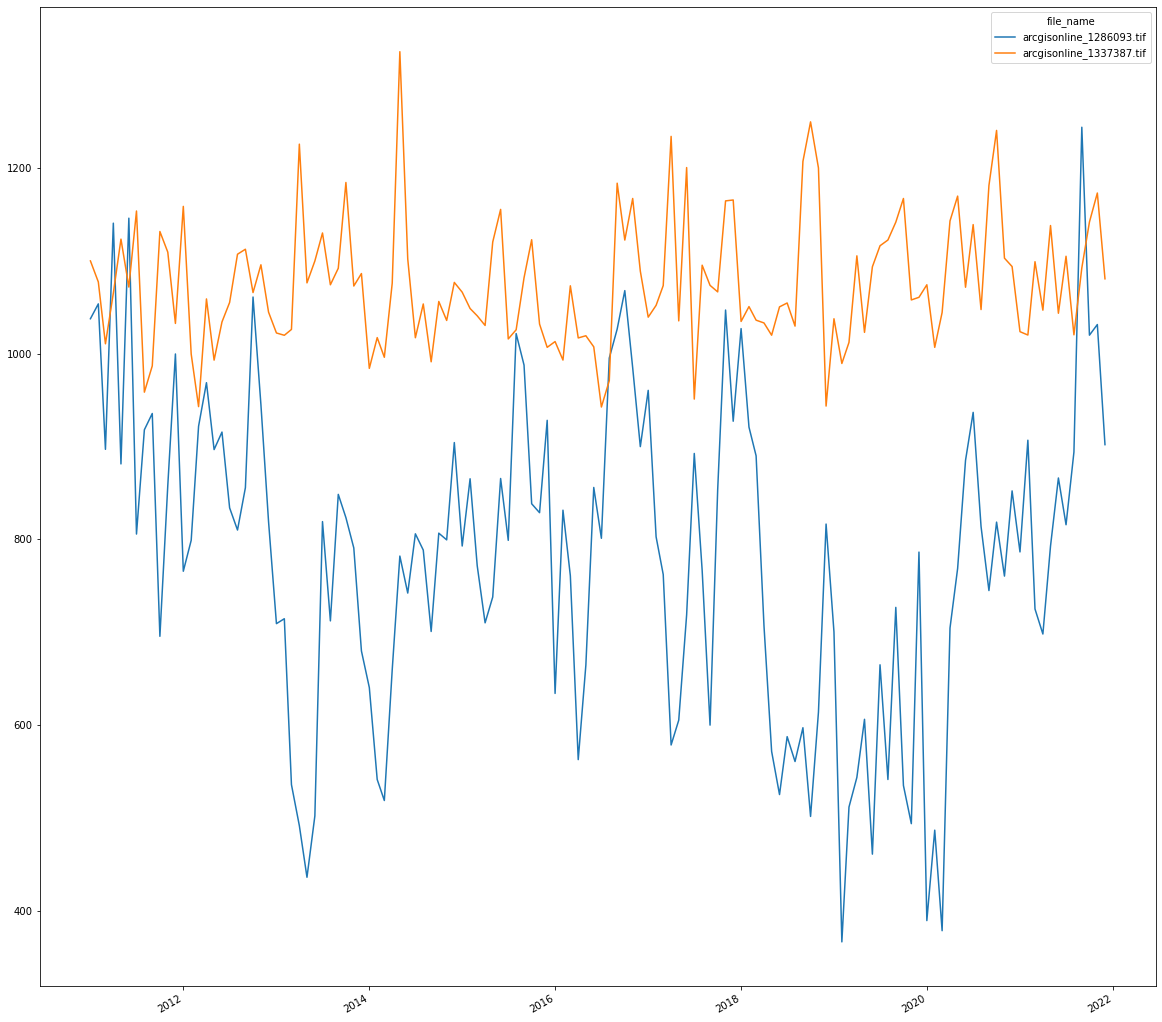

In [29]:
# Plot up some data
dupe_df.iloc[:, : 2].plot.line(figsize=(20,20))